# Inference on Bayesian Network

## Load Data, Create DAG

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,native.country,income
2,5,2,2,0,0,0,3,0,0
3,1,2,0,0,0,0,0,0,0
2,0,2,1,1,0,0,3,0,0
4,0,1,0,1,4,0,3,0,0
1,0,2,0,3,4,1,3,1,0
2,0,3,0,0,0,1,3,0,0


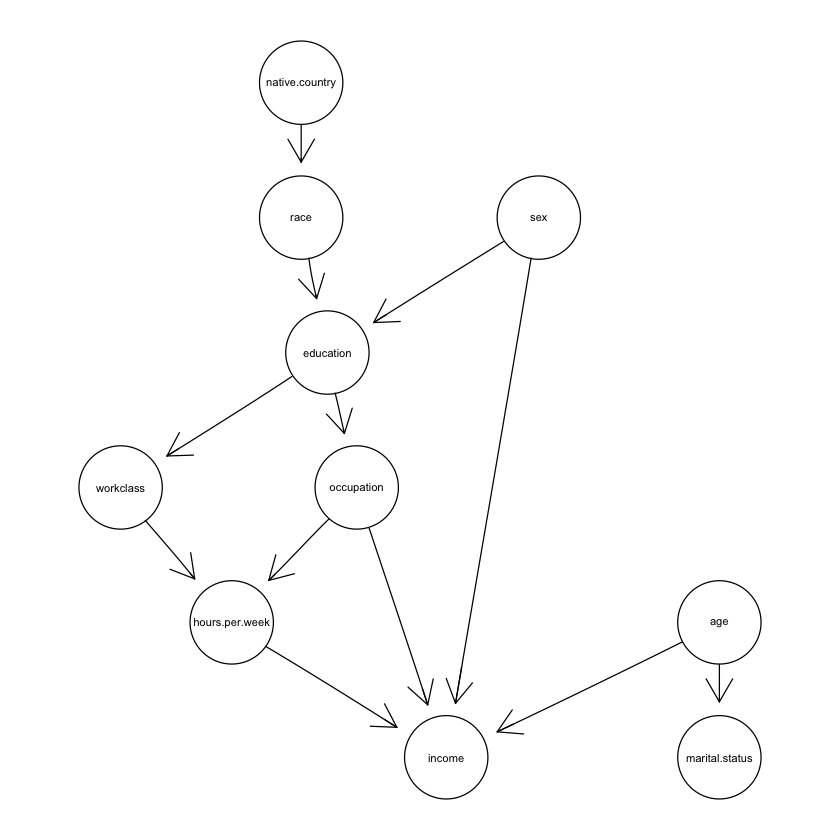

In [2]:
library("gRain")
library("Rgraphviz")
library("dagitty")
library("combinat")

options(warn=-1)
  setwd("/Users/apple1/Dropbox/Uni/Nijmegen/WS17_18/BN")
#setwd("D:/RU/Sem1/Bayesian Networks/Project")
#setwd("/Users/lisa/Documents/Uni/03.SemesterMaster/BN/bn17")
# setwd("C:/Users/Valentin/Uni/RU/Sem1/Bayesian Networks")
data <- read.table(header=T, sep=",", 'adult_cleaned.csv')


our_network <- dag(~ race:native.country + education:race:sex + workclass:education + hours.per.week:workclass:occupation + occupation:education + marital.status:age + income:age:sex:occupation:hours.per.week)
plot(our_network)
head(data)

data[data=="?"]<-NA
data<-data[complete.cases(data),]

## Implied independencies

In [3]:
g <- dagitty( "dag{ native.country -> race -> education -> occupation -> hours.per.week -> income; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; age -> income; age -> marital.status}" )
independencies <- impliedConditionalIndependencies( g )
print(independencies)
print(length(independencies))

age _||_ education
age _||_ hours.per.week
age _||_ native.country
age _||_ occupation
age _||_ race
age _||_ sex
age _||_ workclass
education _||_ hours.per.week | occupation, workclass
education _||_ income | hours.per.week, occupation, sex
education _||_ income | occupation, sex, workclass
education _||_ marital.status
education _||_ native.country | race
hours.per.week _||_ marital.status
hours.per.week _||_ native.country | race
hours.per.week _||_ native.country | education
hours.per.week _||_ native.country | occupation, workclass
hours.per.week _||_ race | education
hours.per.week _||_ race | occupation, workclass
hours.per.week _||_ sex | education
hours.per.week _||_ sex | occupation, workclass
income _||_ marital.status | age
income _||_ native.country | race
income _||_ native.country | education, sex
income _||_ native.country | occupation, sex, workclass
income _||_ native.country | hours.per.week, occupation, sex
income _||_ race | education, sex
income _||_ race | occup

## Test Independencies

In [4]:
test_network <- function(data, independencies, sig_threshold){
    num_test <- 0
    num_failed <- 0
    all <- length(data[,1])
    sig_results <- c()
    # Loop through all found independencies
    for(i in 1:length(independencies)){
        # Get variables and conditioning set
        indp <- independencies[i]
        xyz <- unlist(indp) 
        # If conditioning set is empty testing is easy
        if(length(xyz)==2){
            #Chi-square test rmsea correction to test for implied statistical independence
            tst <- chisq.test(data[,xyz[1]], data[,xyz[2]])
            res <- sqrt(max((tst$statistic - tst$parameter)/(( nrow(data) - 1)*tst$parameter),0))
            #If result is larger than 0.05 we reject the null hypothesis of the variables being independent
            if(res > sig_threshold){
                print(paste('test: ', xyz[1], ' and ', xyz[2]))
                print(res)
                num_failed <- num_failed + 1
                print('-----------------')
            }
            num_test <- num_test + 1
            sig_results <- c(sig_results,res)
        }
        # If conditioning set is not empty testing is more involved
        else{
            failed <- 0
            print(paste(c('test ', xyz[1], ' and ', xyz[2], 'given ', xyz[-(1:2)]), collapse=' '))
            # We have to test for independence given all possible value combinations
            # of the conditioning variables
            strata <- list()
            for(i in 1:length(xyz[-(1:2)])){
                    # Get values of variables sorted by frequency
                    strata[i] <- as.data.frame(sort(table(data[,xyz[2+i]]),decreasing=T))
            }
            # Get all possible combinations of values
            comb_strata = expand.grid(strata)
            visited <- 0
            idx <- 1
            l_res <- c()
            # Test conditions until 80% of data was tested
            while(visited<0.8*all){
                # Get data given conditioning set
                subdata <- data[interaction(data[,xyz[-(1:2)]]) == interaction(comb_strata[idx,]),]
                x <- subdata[,xyz[1]]
                y <- subdata[,xyz[2]]
                # Only test if enough data (unique values) is available
                if(length(unique(x)) < 2 || length(unique(y)) < 2){
                    break
                }
                tst <- chisq.test(x,y)
                res <- sqrt(max((tst$statistic - tst$parameter)/(( nrow(subdata) - 1)*tst$parameter),0))
                if(res > sig_threshold){
                    failed <- 1
                    print(paste(xyz[-(1:2)], ' = ', comb_strata[idx,]),max.levels=0)
                    print(res)

                }
                l_res <- c(l_res, res)
                visited <- visited + nrow(subdata)
                idx <- idx + 1
                num_test <- num_test + 1
            }
            if(failed){
                    num_failed <- num_failed + 1
                    print('-----------------')
            }
            if(length(l_res) > 1){
                # if several results are above threshold save the second largest for robustness
                n <- length(l_res)
                second_res <- sort(l_res,partial=n-1)[n-1]
                sig_results <- c(sig_results,second_res)
            }
            else{
                sig_results <- c(sig_results,l_res[1])
            }

        }
    }
    
    print(paste('Number of tests = ', num_test, collapse=''))
    print(paste('Number of tested independencies = ',length(independencies),collapse=''))
    print(paste('Number of failed independencies = ', num_failed, collapse=''))
    
    return(sig_results)
}




In [5]:
sig_threshold <- 0.05 
sig_results <- test_network(data, independencies, sig_threshold)

[1] "test:  age  and  hours.per.week"
[1] 0.07403111
[1] "-----------------"
[1] "test  education  and  hours.per.week given  occupation workclass"
[1] "occupation  =  4" "workclass  =  1" 
[1] 0.06275108
[1] "-----------------"
[1] "test  education  and  income given  hours.per.week occupation sex"
[1] "hours.per.week  =  1" "occupation  =  1"     "sex  =  1"           
[1] 0.05570996
[1] "hours.per.week  =  2" "occupation  =  1"     "sex  =  1"           
[1] 0.0580566
[1] "hours.per.week  =  6" "occupation  =  1"     "sex  =  1"           
[1] 0.1284068
[1] "hours.per.week  =  1" "occupation  =  2"     "sex  =  1"           
[1] 0.09366923
[1] "hours.per.week  =  2" "occupation  =  2"     "sex  =  1"           
[1] 0.1034253
[1] "hours.per.week  =  3" "occupation  =  2"     "sex  =  1"           
[1] 0.06778869
[1] "hours.per.week  =  4" "occupation  =  2"     "sex  =  1"           
[1] 0.1150442
[1] "hours.per.week  =  5" "occupation  =  2"     "sex  =  1"           
[1] 0.08453084

#### Check rmsea-value distribution to determine cut-off
It can be seen that there is a large drop in frequency between the values 0.06 and 0.07. Therefore we set 0.07 as a significance threshold

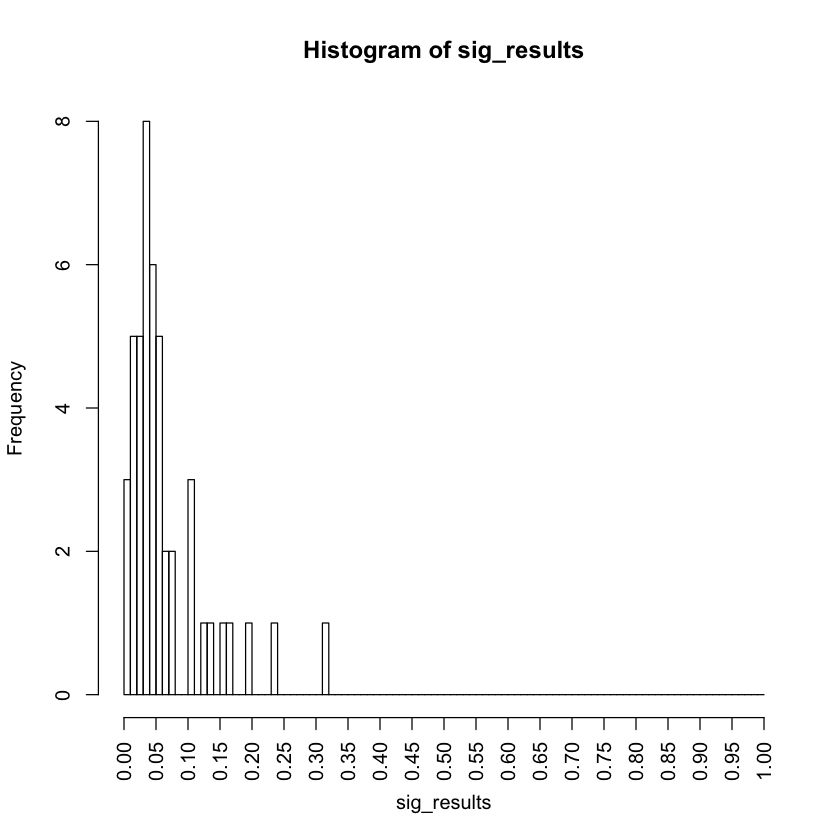

In [6]:
breaks = seq(0,1,0.01)
hist(sig_results,breaks=breaks,xlim=range(breaks),xaxt="n")
axis(1, at = seq(0, 1, by = 0.05), las=2)

In [7]:
# After examination of distribution
sig_threshold <- 0.07 
sig_results <- test_network(data, independencies, sig_threshold)

[1] "test:  age  and  hours.per.week"
[1] 0.07403111
[1] "-----------------"
[1] "test  education  and  hours.per.week given  occupation workclass"
[1] "test  education  and  income given  hours.per.week occupation sex"
[1] "hours.per.week  =  6" "occupation  =  1"     "sex  =  1"           
[1] 0.1284068
[1] "hours.per.week  =  1" "occupation  =  2"     "sex  =  1"           
[1] 0.09366923
[1] "hours.per.week  =  2" "occupation  =  2"     "sex  =  1"           
[1] 0.1034253
[1] "hours.per.week  =  4" "occupation  =  2"     "sex  =  1"           
[1] 0.1150442
[1] "hours.per.week  =  5" "occupation  =  2"     "sex  =  1"           
[1] 0.08453084
[1] "hours.per.week  =  6" "occupation  =  2"     "sex  =  1"           
[1] 0.1606985
[1] "hours.per.week  =  3" "occupation  =  3"     "sex  =  1"           
[1] 0.1607905
[1] "hours.per.week  =  5" "occupation  =  3"     "sex  =  1"           
[1] 0.1638443
[1] "hours.per.week  =  6" "occupation  =  3"     "sex  =  1"           
[1] 0.316

## Adjust Network

In [8]:
g <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; education -> income}" )
independencies <- impliedConditionalIndependencies( g )
print(independencies)
print(length(independencies))

age _||_ education
age _||_ occupation
age _||_ race
age _||_ sex
age _||_ workclass
education _||_ hours.per.week | occupation, sex, workclass
education _||_ marital.status
hours.per.week _||_ marital.status | age
hours.per.week _||_ race | education, sex
hours.per.week _||_ race | occupation, sex, workclass
income _||_ marital.status | age
income _||_ race | education, sex
income _||_ workclass | age, education, hours.per.week, occupation, sex
marital.status _||_ occupation
marital.status _||_ race
marital.status _||_ sex
marital.status _||_ workclass
occupation _||_ race | education, sex
occupation _||_ workclass | education
race _||_ sex
race _||_ workclass | education
sex _||_ workclass | education
[1] 22


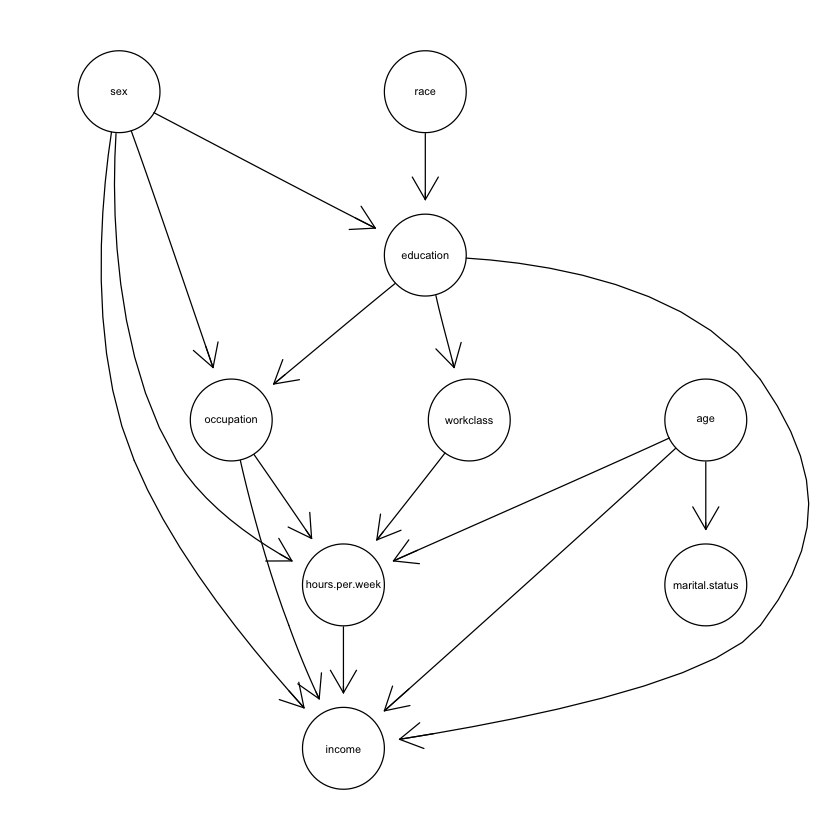

In [9]:
our_network <- dag(~ race + education:race:sex + workclass:education + hours.per.week:workclass:occupation:age:sex + occupation:education:sex + marital.status:age + income:age:sex:occupation:hours.per.week:education)
plot(our_network)

In [10]:
sig_results <- test_network(data, independencies, sig_threshold)

[1] "test  education  and  hours.per.week given  occupation sex workclass"
[1] "test  hours.per.week  and  marital.status given  age"
[1] "test  hours.per.week  and  race given  education sex"
[1] "test  hours.per.week  and  race given  occupation sex workclass"
[1] "test  income  and  marital.status given  age"
[1] "age  =  2"
[1] 0.165575
[1] "age  =  1"
[1] 0.1437892
[1] "age  =  3"
[1] 0.1751547
[1] "age  =  4"
[1] 0.1650351
[1] "-----------------"
[1] "test  income  and  race given  education sex"
[1] "test  income  and  workclass given  age education hours.per.week occupation sex"
[1] "test:  marital.status  and  sex"
[1] 0.190211
[1] "-----------------"
[1] "test  occupation  and  race given  education sex"
[1] "test  occupation  and  workclass given  education"
[1] "test  race  and  workclass given  education"
[1] "test  sex  and  workclass given  education"
[1] "Number of tests =  60"
[1] "Number of tested independencies =  22"
[1] "Number of failed independencies =  2"


## Inference

In [52]:
## Load deleted rows
del_data <- read.table(header=T, sep=",", 'adult_cleaned_deleted.csv')

del_data$native.country <- NULL
data$native.country <- NULL

In [53]:
# Create network object
net1 <- compile( grain( our_network, data, smooth=1 ) )
pp <- extractCPT( data, our_network, smooth=1)

### Marginals

In [54]:
## No evidence income
print('0: <=50k, 1: >50k')
q1 <- querygrain(net1, nodes='income',type = "marginal", evidence = NULL, exclude = TRUE, normalize = TRUE, result = "array", details = 0)
print('Inferred')
print(q1)
print('Frequencies')
t <- table(data['income'])
print(paste(t[[1]] / (t[[1]]+t[[2]]),t[[2]] / (t[[1]]+t[[2]]) , collapse=''))

[1] "0: <=50k, 1: >50k"
[1] "Inferred"
$income
income
        0         1 
0.7373262 0.2626738 

[1] "Frequencies"
[1] "0.751077514753664 0.248922485246336"


### Evidences

In [55]:
## Given White, male
net2 <- setEvidence(net1, c("sex","race"), c("0", "0"),propagate=TRUE)
q2 <- querygrain(net2, nodes='income',type = "marginal")
print(q2)

$income
income
        0         1 
0.6876336 0.3123664 



In [15]:
## Female query Education
net4 <- setEvidence(net1, c("sex"), c("1"),propagate=TRUE)
q4 <- querygrain(net4, nodes='education',type = "marginal")
print(q4)

$education
education
          0           1           2           3           4           5 
0.026269540 0.172740248 0.728205496 0.054126574 0.009622132 0.009036009 



In [16]:
## Male query Education
net5 <- setEvidence(net1, c("sex"), c("0"),propagate=TRUE)
q5 <- querygrain(net5, nodes='education',type = "marginal")
print(q5)

$education
education
         0          1          2          3          4          5 
0.03851813 0.16310385 0.70739143 0.05442639 0.02217918 0.01438102 



In [17]:
# Test (can be deleted)
net4 <- setEvidence(net1, c("sex"), c("0"), propagate=TRUE)
# q4 <- querygrain(gin1c.find, nodes=c("education","native.country","sex"),type = "conditional",result = "data.frame")
q4 <- querygrain(net4, nodes=c("income"),type='marginal')
q5 <- querygrain(net1, nodes=c("income"),type='marginal')

print(q4)
print(q5)

$income
income
        0         1 
0.6885355 0.3114645 

$income
income
        0         1 
0.7373262 0.2626738 



### Missing values

In [18]:
head(del_data)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
4,NA,2,0,NA,1,0,5,1
2,NA,0,5,NA,0,0,3,0
1,NA,2,2,NA,0,0,3,0
5,NA,1,0,NA,0,0,0,0
0,NA,1,2,NA,0,1,2,0
2,NA,1,0,NA,0,0,3,0


In [69]:
predict <- function(data, var_names, verbose){
    new_data <- data
    for(i in 1:dim(data)[1]){
        row <- data[i,]
        given_names <- list()
        given_vals <- list()
        missing_names <- list()
        missing_idx <- list()
        g_idx <- 1
        m_idx <- 1
        for(j in 1:length(row)){
            if(is.na(row[[j]])){
                missing_names[[m_idx]] <- var_names[[j]]
                missing_idx[[m_idx]] <- j
                m_idx <- m_idx + 1
            } else {
                given_names[[g_idx]] <- var_names[[j]]
                given_vals[[g_idx]] <- toString(row[[j]])
                g_idx <- g_idx + 1
            }
        }
        net_ev <- setEvidence(net1, unlist(given_names, use.names=FALSE), unlist(given_vals, use.names=FALSE),propagate=TRUE)
        if(length(missing_names) > 0){
            for(j in 1:length(missing_names)){
                q <- querygrain(net_ev, nodes=missing_names[[j]],type = "marginal")
                if(verbose){
                    print(q)
                    print('Max at')
                    print(which.max(unlist(q, use.names=FALSE)))
                }
                for(a in 1:length(given_names)){
                    given_vals[[a]]
                }
                new_data[i,missing_idx[[j]]] <- which.max(unlist(q, use.names=FALSE)) - 1
            }
        }
        if(verbose){
            print('-----')        
        }
    }
    
    return(new_data)
}

In [60]:
verbose <- FALSE
var_names <- c('age','workclass','education','marital.status','occupation','race','sex','hours.per.week','income')
new_data <- predict(del_data, var_names, verbose)

In [61]:
head(new_data)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
4,1,2,0,1,1,0,5,1
2,1,0,5,2,0,0,3,0
1,1,2,2,2,0,0,3,0
5,1,1,0,2,0,0,0,0
0,1,1,2,3,0,1,2,0
2,1,1,0,2,0,0,3,0


In [62]:
head(del_data)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
4,NA,2,0,NA,1,0,5,1
2,NA,0,5,NA,0,0,3,0
1,NA,2,2,NA,0,0,3,0
5,NA,1,0,NA,0,0,0,0
0,NA,1,2,NA,0,1,2,0
2,NA,1,0,NA,0,0,3,0


In [13]:
write.csv(new_data, file = "../adult_added_missing_vals.csv",row.names=FALSE)

ERROR: Error in is.data.frame(x): object 'new_data' not found


In [26]:
data1 <- read.table(header=T, sep=",", 'adult_cleaned.csv')
data2 <- read.table(header=T, sep=",", 'adult_added_missing_vals.csv')

In [27]:
data1$native.country <- NULL
total <- rbind(data1, data2) 

In [28]:
sig_results <- test_network(total, independencies, sig_threshold)

[1] "test  education  and  hours.per.week given  occupation sex workclass"
[1] "test  hours.per.week  and  marital.status given  age"
[1] "test  hours.per.week  and  race given  education sex"
[1] "test  hours.per.week  and  race given  occupation sex workclass"
[1] "test  income  and  marital.status given  age"
[1] "age  =  2"
[1] 0.1659319
[1] "age  =  1"
[1] 0.143006
[1] "age  =  3"
[1] 0.1736704
[1] "age  =  4"
[1] 0.1650548
[1] "-----------------"
[1] "test  income  and  race given  education sex"
[1] "test  income  and  workclass given  age education hours.per.week occupation sex"
[1] "test:  marital.status  and  sex"
[1] 0.1884615
[1] "-----------------"
[1] "test  occupation  and  race given  education sex"
[1] "test  occupation  and  workclass given  education"
[1] "education  =  1"
[1] 0.07086606
[1] "-----------------"
[1] "test  race  and  workclass given  education"
[1] "test  sex  and  workclass given  education"
[1] "Number of tests =  60"
[1] "Number of tested independe

## Testing

### Load test data without rows with missing values

In [66]:
test_data <- read.table(header=T, sep=",", 'adult_test_cleaned.csv')
test_data$native.country <- NULL
head(test_data)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
1,0,1,2,1,4,0,3,0
2,0,1,0,1,0,0,4,0
1,4,1,0,2,0,0,3,1
3,0,2,0,1,4,0,3,1
2,0,1,2,2,0,0,2,0
5,1,4,0,3,0,0,2,1


### Predict Income

In [67]:
targets <- test_data$income
test_data$income <- NA
head(test_data)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
1,0,1,2,1,4,0,3,NA
2,0,1,0,1,0,0,4,NA
1,4,1,0,2,0,0,3,NA
3,0,2,0,1,4,0,3,NA
2,0,1,2,2,0,0,2,NA
5,1,4,0,3,0,0,2,NA


In [73]:
predicted <- predict(test_data, var_names, verbose)
head(predicted)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
1,0,1,2,1,4,0,3,0
2,0,1,0,1,0,0,4,0
1,4,1,0,2,0,0,3,0
3,0,2,0,1,4,0,3,0
2,0,1,2,2,0,0,2,0
5,1,4,0,3,0,0,2,1


### Print Accuracy

It can be seen that our network has a prediction accuracy of 79.7% - this is comparable to 83% reported in the literature for naive bayes classification

In [74]:
accuracy <- sum(targets == predicted$income)/(length(targets))
print(accuracy)

[1] 0.7971448


### Test on data including missing values

In [130]:
test_data_missing <- read.table(header=T, sep=",", 'adult_test_cleaned_deleted.csv')
test_data_missing$native.country <- NULL
total <- rbind(test_data, test_data_missing) 
targets_missing = c(targets, test_data_missing$income)

#### Replace missing values with average value

In [143]:
total_replaced <- total
for(i in 1:(ncol(total)-1)){   
    total_replaced[is.na(total[,i]), i] <- names(which.max(table(total[,i])))
}

In [144]:
predicted <- predict(total_replaced, var_names, verbose)
head(predicted)
accuracy <- sum(targets_missing == predicted$income)/(length(targets_missing))
print(accuracy)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
1,0,1,2,1,4,0,3,0
2,0,1,0,1,0,0,4,0
1,4,1,0,2,0,0,3,0
3,0,2,0,1,4,0,3,0
2,0,1,2,2,0,0,2,0
5,1,4,0,3,0,0,2,1


[1] 0.812358


#### Predict all missing values

In [105]:
predicted <- predict(total, var_names, verbose)
head(predicted)
accuracy <- sum(targets_missing == predicted$income)/(length(targets_missing))
print(accuracy)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
1,0,1,2,1,4,0,3,0
2,0,1,0,1,0,0,4,0
1,4,1,0,2,0,0,3,0
3,0,2,0,1,4,0,3,0
2,0,1,2,2,0,0,2,0
5,1,4,0,3,0,0,2,1


[1] 0.812358
